# Artificial data, that works well with MI-based feature selection

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def generate_samples(n, n_features, n_informative, random_seed):
    rng = np.random.default_rng(random_seed)
    p = rng.uniform(0.25, 0.75, n_features)
    X = rng.binomial(1, p, (n, n_features))
    y = (X[:, :n_informative].sum(axis=1) > p[:n_informative].sum()).astype(int)
    return X, y, p

## Toy example

In [61]:
X, y, p = generate_samples(20, 3, 2, 123)
X

array([[1, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 1],
       [0, 0, 1],
       [1, 1, 0]], dtype=int64)

In [62]:
y

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [63]:
p

array([0.59117593, 0.27691051, 0.36017994])

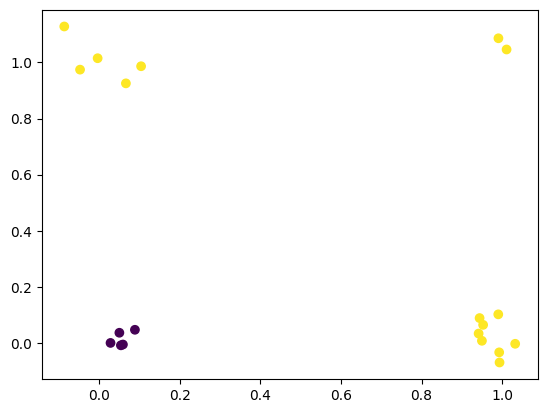

In [25]:
plt.scatter(X[:, 0] + np.random.normal(0, 0.05, len(X)), X[:, 1] + np.random.normal(0, 0.05, len(X)), c=y)

## Application

In [7]:
from Project.feature.FastCMIM import fast_cmim
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel, SelectorMixin
from sklearn.linear_model import LassoCV
from Project.feature.CMIM import CMIMSelector
from Project.feature.JMI import JMISelector

def evaluate_single_method(selector: SelectorMixin, n_informative, name, n_features=None):
    if name != "FastCMIM":
        selected_mask = selector._get_support_mask()
    else:
        selected_mask = selector
    true_mask = np.zeros_like(selected_mask)
    true_mask[:n_informative] = 1
    return [{
        'method': name,
        'accuracy': accuracy_score(true_mask, selected_mask),
        'FDR': 1 - precision_score(true_mask, selected_mask),
        'TPR': recall_score(true_mask, selected_mask)
    }]


def evaluate_methods(n=100, n_informative=2, n_features=5):
    results = []
    CMIM_max_features = 20
    for random_seed in range(20):
        X, y, p = generate_samples(n, n_features, n_informative, random_seed=random_seed)
        # JMI
        jmi_selector = JMISelector()
        jmi_selector.fit(X, y)
        jmi_selector.get_support()
        results += evaluate_single_method(jmi_selector, n_informative, "JMI")
        # CMIM
        cmin_selector = CMIMSelector(max_iter=CMIM_max_features)
        cmin_selector.fit(X, y)
        results += evaluate_single_method(cmin_selector, n_informative, "CMIM")
        # LASSO
        lasso = LassoCV(cv=5, random_state=random_seed, selection='random', alphas=np.linspace(0.01, 0.05, 100), max_iter=10_000, tol=1e-4)
        lasso = lasso.fit(X, y)
        lasso_selector = SelectFromModel(lasso, prefit=True)
        results += evaluate_single_method(lasso_selector, n_informative, "LASSO")
        # SVM
        svm = LinearSVC(penalty='l1', dual=False, max_iter=100_000)
        grid = {'C': [10 ** i for i in range(-5, 5)]}
        svm_grid_search = GridSearchCV(svm, param_grid=grid, scoring='f1').fit(X, y)
        best_svm = svm_grid_search.best_estimator_.fit(X, y)
        svm_selector = SelectFromModel(best_svm)
        results += evaluate_single_method(svm_selector, n_informative, "SVM")

        # FastCMIM
        cmim_selected, scores = fast_cmim(X, y, n_selected_features=CMIM_max_features)
        selected = (np.cumsum(scores) / np.sum(scores)) < 0.99
        cmim_mask = np.zeros(X.shape[1])
        cmim_mask[cmim_selected[selected]] = 1
        results += evaluate_single_method(cmim_mask, n_informative, "FastCMIM", n_features)
    return results

In [23]:
results = []
ns =  [50, 100, 250, 500, 1000, 2500, 5000]
for n in ns:
    results_n = pd.DataFrame(evaluate_methods(n=n, n_features=8, n_informative=3))
    results_n['n'] = n
    results += [results_n]
results = pd.concat(results)

E:\Studies\DataScience-3sem\MathematicalUnderpinningsOfMachineLearning\venv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
results

method  accuracy       FDR       TPR     n
0        JMI     0.750  0.400000  1.000000    50
1       CMIM     0.875  0.000000  0.666667    50
2      LASSO     0.500  0.571429  1.000000    50
3        SVM     0.625  0.500000  1.000000    50
4   FastCMIM     0.875  0.250000  1.000000    50
..       ...       ...       ...       ...   ...
95       JMI     0.750  0.000000  0.333333  5000
96      CMIM     0.875  0.000000  0.666667  5000
97     LASSO     1.000  0.000000  1.000000  5000
98       SVM     1.000  0.000000  1.000000  5000
99  FastCMIM     0.875  0.000000  0.666667  5000

[700 rows x 5 columns]

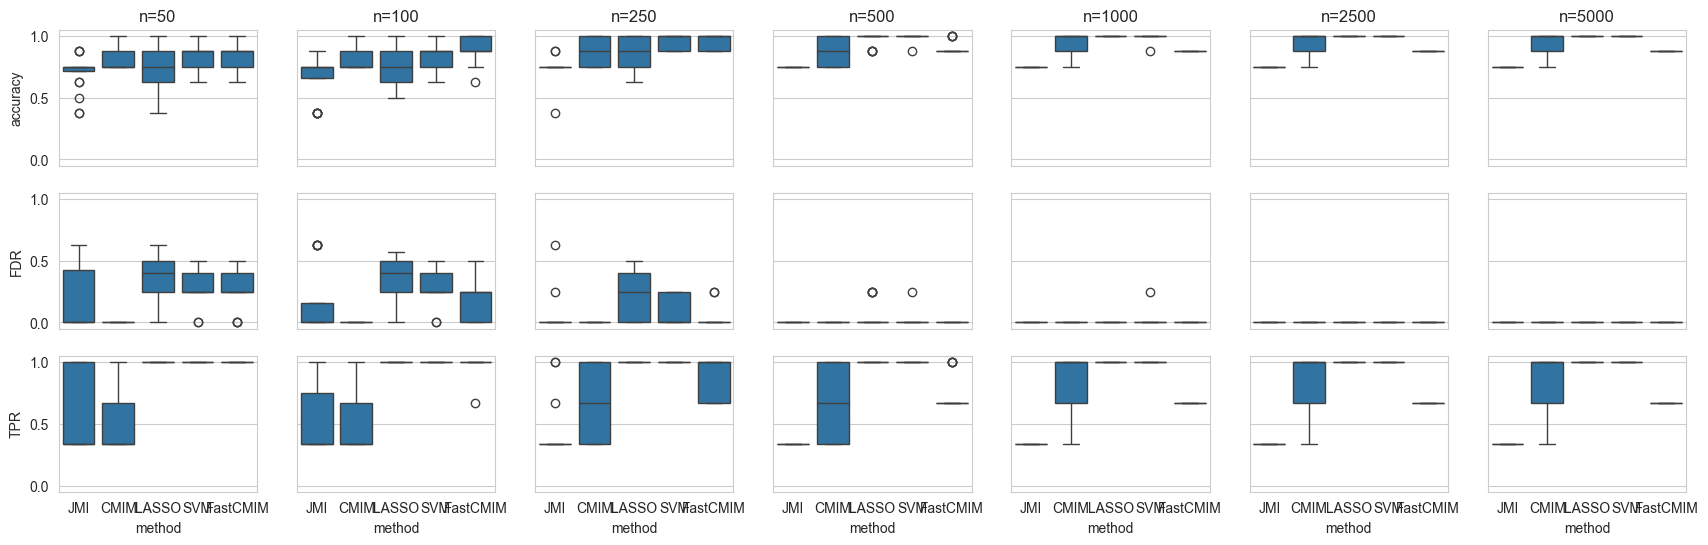

In [30]:
fig, ax = plt.subplots(3, len(ns), sharex=True, sharey=True,  figsize=(21, 6))
for i, n in enumerate(ns):
    sns.boxplot(results[results['n'] == n], x='method', y='accuracy', ax=ax[0][i])
    sns.boxplot(results[results['n'] == n], x='method', y='FDR', ax=ax[1][i])
    sns.boxplot(results[results['n'] == n], x='method', y='TPR', ax=ax[2][i])
for ax_, col in zip(ax[0], [f"n={n}" for n in ns]):
    ax_.set_title(col)


<Axes: xlabel='n', ylabel='TPR'>

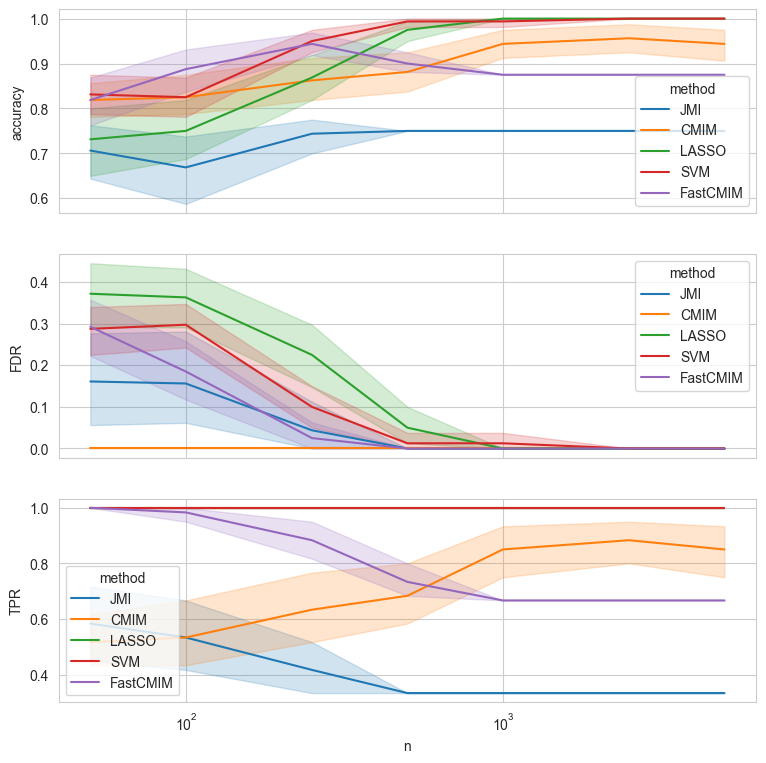

In [27]:
fig, ax = plt.subplots(3, sharex=True, figsize=(9, 9))
for i in range(3):
    ax[i].set_xscale('log')
sns.lineplot(results, x='n', y='accuracy', hue='method', ax=ax[0])
sns.lineplot(results, x='n', y='FDR', hue='method', ax=ax[1])
sns.lineplot(results, x='n', y='TPR', hue='method', ax=ax[2])